# Wikipedia Articles NLP Project

## Overview

This notebook performs an NLP on random articles collected from [Wikipedia](https://en.wikipedia.org/). It explored different feature extraction and clustering methods.

## Imports

In [43]:
from gensim import downloader as model_api
import hdbscan
from kneed import KneeLocator
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import requests
import scipy.cluster.hierarchy as sch
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import time
import torch

## Data Collection

In [2]:
url = 'https://en.wikipedia.org/w/api.php'
#csv_path = 'data/wiki_articles.csv'
csv_path = 'wiki_articles.csv'

In [49]:
def get_random_titles(n:int) -> np.array:
    titles = []
    while len(titles) < n:
        try:
            params = {
                'action': 'query',
                'list': 'random',
                'rnnamespace': 0,  # Only articles
                'rnlimit': min(50, n - len(titles)),
                'format': 'json'
            }
            response = requests.get(url, params=params)
            data = response.json()
            batch = [item['title'] for item in data['query']['random']]
            titles.extend(batch)
            time.sleep(0.5)
        except Exception as e:
            print('Error:', e)
            time.sleep(1)
    return np.array(titles)

In [50]:
def get_article_text(title:str) -> str:
    params = {
        'action': 'query',
        'format': 'json',
        'prop': 'extracts',
        'explaintext': True,
        'titles': title
    }
    try:
        response = requests.get(url, params=params)
        pages = response.json()['query']['pages']
        page = next(iter(pages.values()))
        return page.get('extract', '')
    except Exception as e:
        print(f'Error fetching {title}: {e}')
        return ''

In [51]:
def remove_unwanted_sections(text):
    unwanted_sections = [
        r'==\s*See also\s*==',
        r'==\s*References\s*==',
        r'==\s*Further reading\s*==',
        r'==\s*External links\s*==',
        r'==\s*Notes\s*==',
        r'==\s*Sources\s*==',
        r'==\s*Bibliography\s*==',
        r'==\s*Footnotes\s*=='
    ]

    pattern = re.compile('|'.join(unwanted_sections), re.IGNORECASE)
    match = pattern.search(text)

    if match:
        return text[:match.start()].strip()
    else:
        return text.strip()

In [52]:
def full_clean(text):
    core = remove_unwanted_sections(text)
    core = re.sub(r'\n{2,}', '\n', core)
    return core.strip()

In [53]:
def export_list_to_csv(data:list[dict], csv_path:str) -> None:
	df = pd.DataFrame(data)
	if not os.path.isfile(csv_path):
		df.to_csv(csv_path, index=False)
	else:
		df.to_csv(csv_path, index=False, header=False, mode='a')

In [ ]:
# Get 10000 random articles from Wikipedia
titles = get_random_titles(10000)
chunks = np.array_split(titles, 100)

In [ ]:
# Export data in chunks
for i, chunk in enumerate(chunks):
	print(f'Chunk {i + 1}/{len(chunks)}')
	wiki_list = []
	for title in chunk:
		text = get_article_text(title)
		if text and len(text) > 300:  # Filter out very short pages
			wiki_list.append({
				'title': title,
				'text': full_clean(text)
			})
		time.sleep(0.5) # Sleep for 500 ms to avoid rate-limiting
	export_list_to_csv(wiki_list, csv_path)
	print(f'Added {len(wiki_list)}/{len(chunk)} articles to CSV file.')

## EDA

In [5]:
# Load data
df = pd.read_csv(csv_path)
df.head()

,title,text
0,Biff Schlitzer,"Victor Joseph ""Biff"" Schlitzer (December 4, 18..."
1,Prabhash Kumar,"Prabhash Kumar is an Indian politician, farmer..."
2,San Carlos Formation,The San Carlos Formation is a geological forma...
3,2023 in Ohio,The following is a list of events of the year ...
4,2009 Iowa special elections,The 2009 Iowa state special elections were hel...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8595 entries, 0 to 8594
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   8595 non-null   object
 1   text    8595 non-null   object
dtypes: object(2)
memory usage: 134.4+ KB


In [7]:
# Get smallest text
index = df['text'].str.len().idxmin()
df.iloc[index]

,5992
title,List of volcanoes in El Salvador
text,This is a list of active and extinct volcanoes...


In [8]:
# Get biggest text
index = df['text'].str.len().idxmax()
df.iloc[index]

,5321
title,Divided differences
text,"In mathematics, divided differences is an algo..."


## Data Preprocessing

### GloVe

In [9]:
# Tokenize texts by removing punctuation and special characters
# and lowercasing everything
replaceDict = dict({
'{':" ", '}':" ", ',':"", '.':" ", '!':" ", '\\':" ", '/':" ", '$':" ", '%':" ",
'^':" ", '?':" ", '\'':" ", '"':" ", '(':" ", ')':" ", '*':" ", '+':" ", '-':" ",
'=':" ", ':':" ", ';':" ", ']':" ", '[':" ", '`':" ", '~':" ",
})

rep = dict((re.escape(k),v) for k, v in replaceDict.items())
pattern = re.compile('|'.join(rep.keys()))

def replacer(text):
    return rep[re.escape(text.group(0))]

words = df['text'].str.replace(pattern, replacer, regex=True).str.lower().str.split()
words = pd.DataFrame(words.tolist())

In [10]:
word_vectors = model_api.load("glove-wiki-gigaword-50")

[==================================================] 100.0% 66.0/66.0MB downloaded


In [11]:
# Function to retrieve the word vector or return a zero vector if the word is not found
def get_word_vector(word):
    if word in word_vectors:
        return word_vectors[word]
    else:
        return np.zeros(word_vectors.vector_size)

# Function to map a text to its vector representation by summing the word vectors
def map_text_to_vector(page):
    return np.sum([get_word_vector(word) for word in page if pd.notna(word)], axis=0)

# Apply the mapping function to each text and create a DataFrame of the results
glove_emb = pd.DataFrame(words.apply(map_text_to_vector, axis=1).tolist())
glove_emb

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-25.553197,61.277992,-6.441907,-1.327819,33.129767,25.303264,-93.681521,-16.925939,-39.743567,-34.605831,...,-31.948293,-17.013292,7.921901,-10.060203,-43.326178,41.130120,-28.867548,-40.196636,-8.029011,-6.774925
1,1.704619,-1.517041,-13.325157,5.417937,20.572402,23.046139,-10.669863,-4.731333,-16.040038,-24.081318,...,-27.581619,14.695299,-22.071071,-11.928519,-20.945080,10.538783,-21.423375,-22.582989,19.028705,-20.659330
2,17.696770,2.319915,-2.985669,5.802332,11.713197,3.547520,-16.159113,-15.404687,-11.138138,-3.644905,...,-26.690475,-17.304464,2.805483,2.516293,0.250916,5.042878,6.546632,-9.455825,2.516218,-19.384553
3,57.877136,42.455009,17.792969,-2.447541,9.637690,54.997059,-98.312935,5.448763,0.324308,-72.113289,...,-66.280624,-2.030703,29.818583,-25.870623,-49.491760,43.662933,-53.715706,-36.119362,10.410617,-42.222218
4,4.474286,20.002575,7.467521,10.103029,37.283440,48.269833,-125.686661,-12.588920,-42.947601,-100.732811,...,-80.048775,35.040638,-52.696964,-45.672440,-89.739273,49.484070,-88.131134,-34.871624,8.551754,27.011698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8590,14.352584,122.384755,-170.521032,-47.543207,33.140047,40.247651,-144.909884,17.184558,-138.784235,-16.838819,...,-45.112582,18.165843,-47.235383,-89.321172,-80.017884,43.918467,-65.476791,-84.576976,-123.467156,-24.511413
8591,186.930886,-73.040578,-125.070949,37.098090,223.528212,191.890156,-199.127123,-234.222369,-46.272845,37.687762,...,22.619779,59.103097,-3.399424,27.933238,331.744119,261.918040,-57.953918,-41.787180,-38.495136,-91.641842
8592,15.554881,26.999107,-32.302677,-13.859942,20.643557,-5.603209,-58.670879,-1.185496,-48.660622,-19.573153,...,-22.711718,4.816690,-11.640561,-36.836224,-58.727997,22.536022,-32.802155,-52.557323,16.080572,-19.773840
8593,53.355042,-24.083059,-6.758219,-5.503126,61.069004,32.600834,-51.542694,7.272554,-10.884201,-61.907169,...,-72.853905,36.391407,35.984333,-12.220505,-5.377378,25.349607,-92.599640,-37.820564,24.898485,-86.716850


### Sentence Transformer

In [12]:
# Load model
model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
# Calculate embeddings
mini_emb = pd.DataFrame(model.encode(df['text']))
mini_emb

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.023374,0.023269,-0.103945,-0.033877,0.031884,0.100352,-0.051282,0.155663,-0.035584,0.051362,...,-0.053423,-0.014926,-0.045564,-0.063073,0.016583,-0.078675,0.018316,-0.048807,-0.053580,-0.006450
1,0.001867,-0.012857,-0.052250,-0.035741,0.041092,0.021050,0.093268,-0.023004,-0.087791,0.028738,...,-0.052659,0.017524,-0.082142,-0.061607,-0.000720,0.023933,0.108369,0.060540,-0.015630,-0.011093
2,-0.051594,0.027089,-0.045995,0.067701,-0.045514,-0.002171,-0.086146,-0.015811,-0.035470,-0.026100,...,0.005135,0.006779,0.050991,0.040364,-0.004147,0.011562,-0.047039,0.027455,0.086669,-0.001813
3,-0.006973,0.010959,0.037496,0.016119,0.095530,0.044021,-0.007896,0.041771,-0.131271,0.058207,...,0.041905,0.019995,-0.004059,-0.129669,0.002306,-0.022474,-0.031808,0.017117,0.007192,0.009654
4,-0.046682,-0.012143,0.086666,-0.046343,0.007200,0.052154,-0.024122,0.040913,0.006559,0.040980,...,-0.044681,-0.068946,-0.053276,-0.181910,0.004719,0.064600,0.025116,0.041235,0.016052,-0.075555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8590,0.008887,0.017314,-0.041147,-0.014189,-0.073766,0.079026,-0.019779,0.052027,-0.037399,0.011336,...,0.018744,-0.022396,-0.025683,0.030633,0.007230,-0.019306,0.007542,0.079803,-0.048633,-0.000934
8591,-0.013043,-0.084558,-0.066673,0.016100,0.024330,-0.031969,0.008016,-0.021110,0.055534,-0.042198,...,-0.031272,0.039986,0.023300,-0.063697,0.106172,-0.044735,-0.046021,0.077347,0.082478,0.018576
8592,0.056743,-0.016630,-0.045755,0.021144,-0.031342,-0.050017,-0.061236,0.062345,0.089322,-0.009769,...,-0.092888,0.007519,0.099991,0.052765,0.022278,0.003323,-0.021144,-0.013760,-0.052189,-0.044215
8593,0.059751,0.089780,-0.048822,0.020530,0.057927,0.023562,0.012857,0.002716,0.015486,0.049756,...,0.021733,0.056091,0.006063,-0.078170,0.012723,-0.022446,0.086766,-0.044068,0.004002,-0.003946


## Unsupervised Learning

Three different clustering methods will be explored. The best one will be selected for analyzing and visualization.

### K-Means

Two metrics will be used to determine the optimal k: **Sum of Squared Distances (SSD)** and the **Silhouette Score**. The same metrics will be used to determine the best feature extraction technique.

#### Find optimal K

In [14]:
def create_models(data:pd.DataFrame) -> pd.DataFrame:
  models = []
  for k in range(2, 31):
      kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
      kmeans.fit(data)
      labels = kmeans.labels_
      models.append({
          'k': k,
          'ssd': kmeans.inertia_,
          'silhouette': silhouette_score(data, labels, metric='euclidean'),
      })

  models_df = pd.DataFrame(models).set_index('k')
  return models_df

In [15]:
def display_k_plots(data:pd.DataFrame, technique:str) -> None:
  fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,8), sharex=True)

  # Elbow Method
  kneedle = KneeLocator(data.index, data['ssd'], curve='convex', direction='decreasing')
  optimal_k = kneedle.elbow
  optimal_score = data.loc[optimal_k, 'ssd']
  ax1.plot(data['ssd'], marker='s')
  ax1.set_ylabel('SSD')
  ax1.axvline(x=optimal_k, color='black', linestyle='--')
  ax1.annotate(f'elbow at k = {optimal_k}, score = {round(optimal_score, 4)}', xy=(optimal_k, optimal_score))

  # Silhouette Score
  optimal_k = data['silhouette'].idxmax()
  max_score = data['silhouette'].max()
  ax2.plot(data['silhouette'], marker='s')
  ax2.set_xlabel('k')
  ax2.set_ylabel('Silhouette Score')
  ax2.axvline(x=optimal_k, color='black', linestyle='--')
  ax2.annotate(f'max score at k = {optimal_k}, score = {round(max_score, 4)}', xy=(optimal_k, max_score))

  fig.suptitle(f'Different Metrics for Optimal K ({technique})')
  fig.tight_layout()
  plt.show()

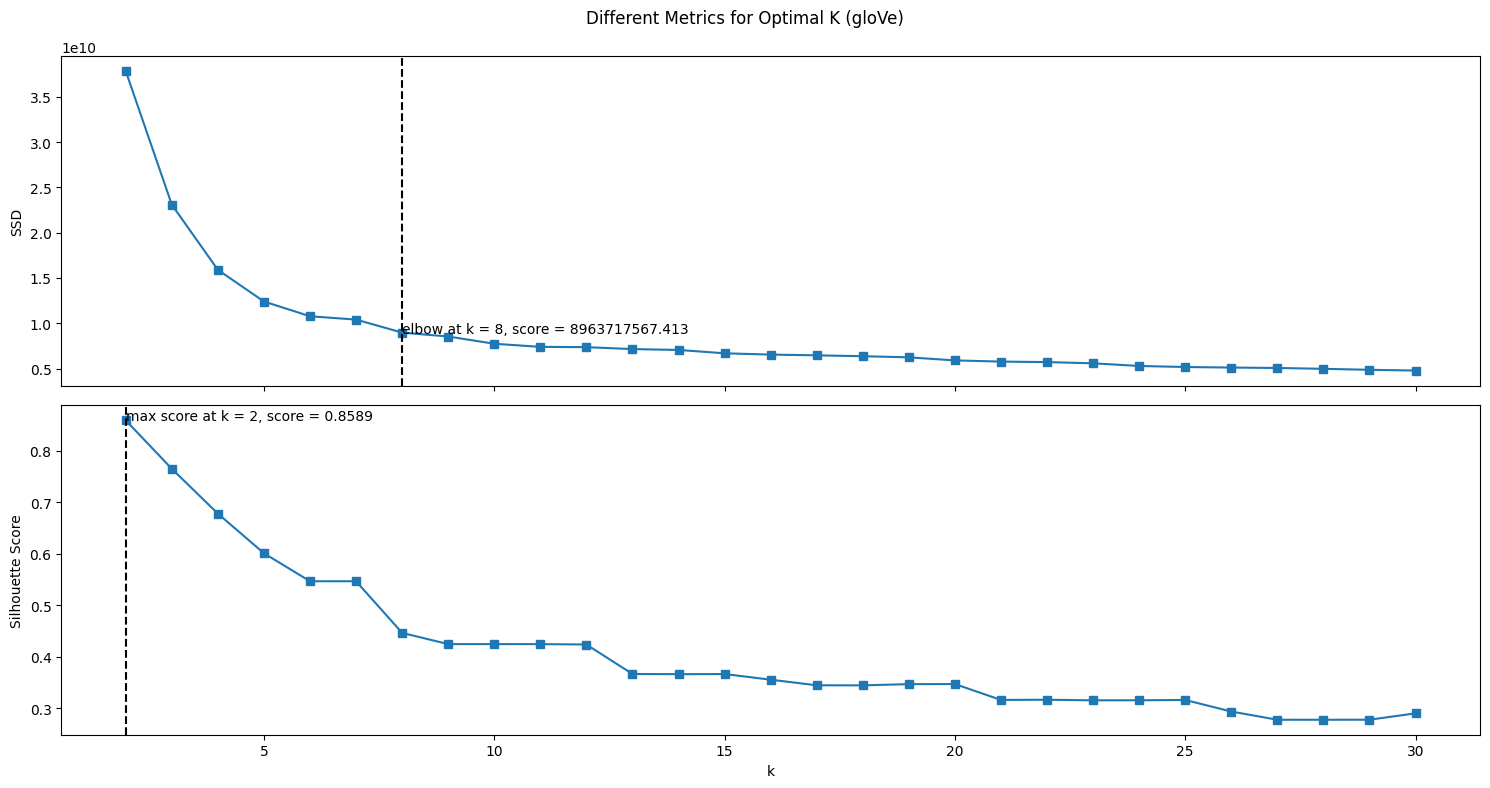

In [16]:
# Display plots for gloVe
metrics_df = create_models(glove_emb)
display_k_plots(metrics_df, 'gloVe')

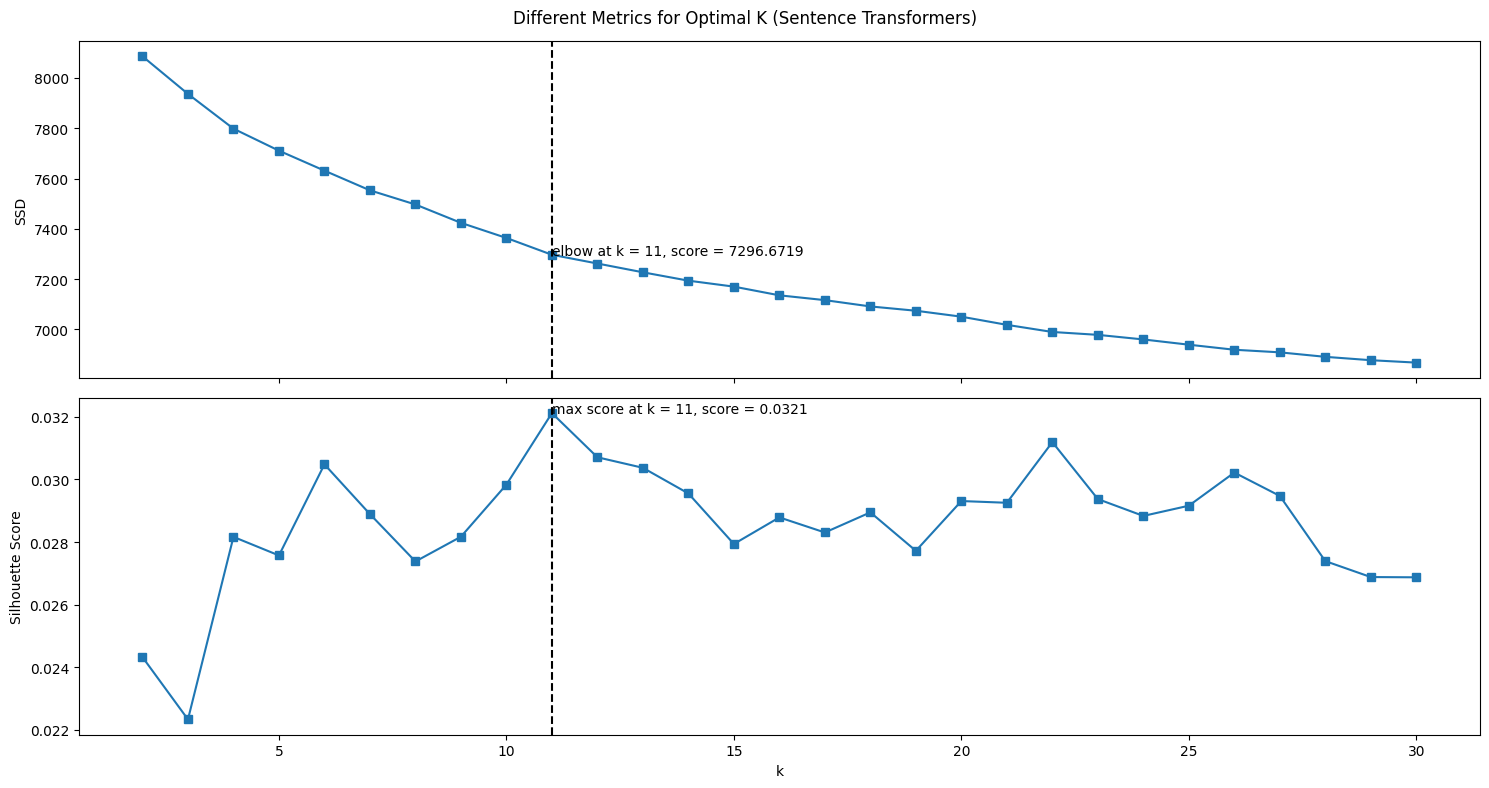

In [17]:
# Display plots for all-MiniLM-L6-v2
metrics_df = create_models(mini_emb)
display_k_plots(metrics_df, 'Sentence Transformers')

When calculating the optimal k value for the sentence transformers embeddings, the same optimal k value is found for both metrics. It seems that the sentence transformers performs better than GloVe. Also, 11 seems to be a reasonable number of clusters. The embeddings calculated with the sentence transformer will be used for the 2 other clustering methods.

#### Fit model

In [18]:
kmeans = KMeans(n_clusters=11, random_state=42)
kmeans.fit(mini_emb)

KMeans(n_clusters=11, random_state=42)

In [19]:
labels = kmeans.labels_
df.insert(0, 'cluster', labels)

#### Analyse Clusters

In [20]:
cluster0 = df[df['cluster'] == 0]
cluster0.sample(10)

,cluster,title,text
8356,0,Kharshedji Rustomji Cama,"Kharshedji Rustomji Cama (1831–1909), often kn..."
2561,0,Barak Abramov,Barak Abramov (Hebrew: ברק אברמוב; born 1979) ...
5345,0,Mirzagarh,Mirzagarh is a village in Singhpur block of Ra...
7067,0,Zhenan,"Zhenan may refer to:\nZhen'an County (镇安县), Sh..."
7187,0,Kapelwa Sikota,Kapelwa Sikota (1928–2006) was the first Zambi...
329,0,Liu Congxiao,"Liu Congxiao (Chinese: 留從效; 906-962), formally..."
3124,0,Ngọc Sơn Temple,"The Ngọc Sơn Temple (Vietnamese: Đền Ngọc Sơn,..."
2887,0,Athirthikal,"Athirthikal is a 1988 Indian Malayalam film, d..."
6313,0,Yoga Sutras of Patanjali,The Yoga Sutras of Patañjali (IAST: Patañjali ...
6140,0,Old Hruaikawn,Hruaikawn (old) is a village in the Champhai d...


In [21]:
cluster1 = df[df['cluster'] == 1]
cluster1.sample(10)

,cluster,title,text
2414,1,Pityrodia chrysocalyx,Pityrodia chrysocalyx is a flowering plant in ...
1335,1,Armada (moth),Armada is a genus of moths of the family Noctu...
8052,1,Dichagyris acclivis,Dichagyris acclivis is a moth of the family No...
5787,1,Monic languages,The Monic languages are a branch of the Austr...
1825,1,Cleochus,"In Greek mythology, Cleochus (Ancient Greek: Κ..."
6730,1,Cantrainea sunderlandi,Cantrainea sunderlandi is a species of small s...
7957,1,Lygodactylus williamsi,Lygodactylus williamsi is a critically endange...
8396,1,Shortfinned worm eel,The shortfinned worm eel (Scolecenchelys austr...
3274,1,Elachyophtalma meeki,Elachyophtalma meeki is a moth in the family B...
1100,1,Sparganothis chambersana,Sparganothis chambersana is a species of moth ...


In [22]:
cluster2 = df[df['cluster'] == 2]
cluster2.sample(10)

,cluster,title,text
3539,2,Ángel Villacampa,Ángel Villacampa Carrasco (born 14 December 19...
6740,2,Antonio Sacconi,Antonio Sacconi (5 October 1895 – 22 December ...
1521,2,Jules Monge,Jules Monge (25 December 1855 – 1 July 1934) w...
3997,2,Garcia II of Kongo,"Garcia II Nkanga a Lukeni a Nzenze a Ntumba, a..."
1566,2,Elvira Ríos,"María Elvira Gallegos Ríos (November 16, 1913 ..."
5302,2,2010 in São Tomé and Príncipe,The following lists events that happened durin...
7886,2,Giovana Queiroz,Giovana Queiroz Costa Garbelini (born 21 June ...
5387,2,Louis Émile Gratia,Louis Émile Georges Gratia (17 September 1878 ...
7551,2,Claude Villeneuve,Claude Villeneuve (November 1954 – 19 May 2024...
4601,2,Alfonso de Portago,"Alfonso Cabeza de Vaca y Leighton, 11th Marque..."


In [23]:
cluster3 = df[df['cluster'] == 3]
cluster3.sample(10)

,cluster,title,text
2207,3,Donald Ray Pollock,"Donald Ray Pollock (born December 23, 1954) is..."
2395,3,List of original characters in The Lord of the...,This is a list of original characters in The L...
3191,3,Joanna Ampil,Joanna Ampil is a musical theatre and film act...
6949,3,Outrapo,"Outrapo stands for ""Ouvroir de tragicomédie po..."
7607,3,Morton Marcus,Morton Marcus (1936–2009) was an American poet...
1950,3,Tatyana Vasilyeva,Tatyana Grigoryevna Vasilyeva (Russian: Татья́...
4679,3,The Big Art Project,The Big Art Project (also known as Big Art) is...
6537,3,Ballet Theatre of Maryland,Ballet Theatre of Maryland is based in Annapol...
3015,3,Florida Kingsley,Florida Kingsley (1867 - 1937) was an actress ...
6985,3,Beavis and Butt-Head in Virtual Stupidity,Beavis and Butt-Head in Virtual Stupidity is a...


In [24]:
cluster4 = df[df['cluster'] == 4]
cluster4.sample(10)

,cluster,title,text
7985,4,"John Brown (basketball, born 1992)","John Brown III (born January 28, 1992) is an A..."
8506,4,Henry Gullane,Henry Gullane (19 May 1874 – 2 May 1907) was a...
2668,4,Muhammad Shamsid-Deen,"Muhammad Shamsid-Deen (born January 16, 1969) ..."
1338,4,Ian Shield,Ian Noel Ridley Shield (24 December 1914 – 22...
4249,4,Liu Heng (footballer),Liu Heng (simplified Chinese: 刘恒; traditional ...
7372,4,Sean O'Connell (fighter),"Sean O'Connell (born September 2, 1983) is an ..."
1729,4,1978 Oklahoma Sooners football team,The 1978 Oklahoma Sooners football team repres...
791,4,Matt Quatraro,Matthew John Quatraro ( kwah-TRAIR-oh; born No...
538,4,North West Senior League,The North West Senior League is the provincial...
6218,4,1878–79 Heart of Midlothian F.C. season,Season 1878–79 was the fourth season in which ...


In [25]:
cluster5 = df[df['cluster'] == 5]
cluster5.sample(10)

,cluster,title,text
4609,5,Commix,Commix is an English drum and bass project fro...
1168,5,S-X discography,English singer S-X has released five studio al...
7338,5,Jo + Jazz,Jo + Jazz is a 1960 album recorded by Jo Staff...
3239,5,Tomoko Sugawara,"Tomoko Sugawara is a harpist from Tokyo, Japan..."
4310,5,Quynh Anh,"Quynh Anh Pham (born 16 January 1987 in Liège,..."
7909,5,In the Land of Grey and Pink,In the Land of Grey and Pink is the third albu...
373,5,Do You Know (What It Takes),"""Do You Know (What It Takes)"" is a song by Swe..."
6021,5,Yoshi City,"""Yoshi City"" is a song by Swedish rapper Yung ..."
1129,5,(I Got No Kick Against) Modern Jazz,(I Got No Kick Against) Modern Jazz is a 1995 ...
987,5,Jerry Stevenson (musician),"Jerry Stevenson, (born in Kent, England) is an..."


In [26]:
cluster6 = df[df['cluster'] == 6]
cluster6.sample(10)

,cluster,title,text
1426,6,"Portal, Georgia","Portal is a town in Bulloch County, Georgia, U..."
4177,6,"Smith County, Tennessee",Smith County is a county in the U.S. state of ...
2353,6,Lake Superior and Ishpeming 18,Lake Superior and Ishpeming Railroad No. 18 is...
2816,6,"Peak's Suburban Addition, Dallas",Peak's Suburban Addition is a historic residen...
1627,6,Azay-le-Ferron,Azay-le-Ferron (French pronunciation: [azɛ lə ...
5375,6,Heidelberg Hotel,"The Heidelberg Hotel was a hotel in Jackson, M..."
84,6,Edward H. Lane House,The Edward H. Lane House is an historic house ...
3862,6,"Cedar Canyon, South Dakota",Cedar Canyon is an unincorporated community in...
7141,6,Castle (District Electoral Area),Castle is one of the ten district electoral ar...
6328,6,St Saviour's Cathedral,St Saviour's Cathedral or variations may refer...


In [27]:
cluster7 = df[df['cluster'] == 7]
cluster7.sample(10)

,cluster,title,text
334,7,Ingrid Mertig,Ingrid Mertig is a German materials scientist ...
3787,7,Fung Wah Bus Transportation,Fung Wah Bus Transportation Inc. (Chinese: 風華巴...
4347,7,Palytoxin,"Palytoxin, PTX or PLTX is an intense vasoconst..."
2571,7,Grain damage,Grain damage is any degradation in the quality...
7614,7,Shrek n' Roll,"Shrek n' Roll, also known as DreamWorks Shrek-..."
5420,7,Alliance–Union universe,The Alliance–Union universe is a fictional uni...
3956,7,Meter stamp,"A meter stamp, or meter mark, is the impressio..."
6316,7,Radiotrophic fungus,Radiotrophic fungi are fungi that can perform ...
7268,7,KVSH,"KVSH (940 AM, ""Heart City Radio"") is a radio s..."
8225,7,Mediaspree,Mediaspree is one of the largest property inve...


In [28]:
cluster8 = df[df['cluster'] == 8]
cluster8.sample(10)

,cluster,title,text
4034,8,Våga,Våga may refer to the following locations:\nVå...
8575,8,Battle of Ochmatów (1644),The Battle of Okhmativ or Battle of Ochmatów (...
4722,8,Orest Miller,Orest Fyodorovich Miller (Russian: Оре́ст Фёдо...
3930,8,Polish Criminal Police,The Polish Criminal Police (Polish: Polska Pol...
4009,8,Shal akyn District,"Shal akyn (Kazakh: Шал ақын ауданы, Şal aqyn a..."
6114,8,Siczki,Siczki [ˈɕit͡ʂki] is a village in the administ...
840,8,Montenegro vilayet,The Vilayet of the Black Mountain (or Monteneg...
6482,8,"Bagniewo, Pomeranian Voivodeship",Bagniewo [baɡˈɲɛvɔ] is a village in the admini...
8498,8,László Passuth,"László Passuth (Budapest, Hungary July 15, 190..."
5712,8,Battle of Bereza Kartuska,The Battle of Bereza Kartuska was fought betwe...


In [29]:
cluster9 = df[df['cluster'] == 9]
cluster9.sample(10)

,cluster,title,text
947,9,Best of the Best: Championship Karate,Best of the Best: Championship Karate is a 199...
7375,9,2024 4 Hours of Imola,The 2024 4 Hours of Imola was an endurance spo...
5169,9,Andriy Pohrebnyak,Andriy Pohrebnyak (Ukrainian: Андрій Погребняк...
8441,9,North Korea at the 2014 Summer Youth Olympics,North Korea competed at the 2014 Summer Youth ...
1166,9,Football in Macau,The sport of football in Macau is run by the A...
7621,9,Artūrs Lazdiņš,Artūrs Lazdiņš (born 9 April 1997) is a Latvia...
1348,9,2015–16 Serbian League East,The 2015–16 Serbian League East is the 13th se...
4547,9,Football rivalries in Belgium,This is a list of the main association footbal...
4025,9,2011–12 Lithuanian Football Cup,The 2011–12 Lithuanian Football Cup was the 23...
6408,9,2018 New Zealand Open (badminton),The 2018 New Zealand Open (officially known as...


In [30]:
cluster10 = df[df['cluster'] == 10]
cluster10.sample(10)

,cluster,title,text
2031,10,The Strickland Press,The Strickland Press was an anarchist publishi...
1918,10,"David Brookman, Baron Brookman","David Keith Brookman, Baron Brookman (born 3 J..."
2993,10,General Wilson,General Wilson may refer to:\n== United Kingdo...
7954,10,HMS Crocodile (1806),HMS Crocodile was a 22-gun sixth-rate post-shi...
4164,10,Natal–Zululand border incident,"On 17 September 1878, a British surveyor for t..."
3184,10,James Kirton (MP for Wells),"James Kirton (died 1611), of London and West C..."
1389,10,Andy O'Mahony,Andy O'Mahony is an Irish broadcast journalist...
6198,10,Banting House,Banting House is a former residence and curren...
6551,10,1700s in literature,== Events ==\n1709 : Tatler founded by Richard...
3223,10,Friedrich Graf von der Schulenburg,Friedrich Bernhard Karl Gustav Ulrich Erich Gr...


##### Observations

0. Asian culture
1. Animals
2. Culture of Spanish and Portuguese-speaking countries
3. People in the show-business, fictional characters, books, movies, writers
4. Team sports
5. Musicians, albumns, songs
6. Cities, schools, parks, stations (urban buildings)
7. Historical events, agriculture, transportation, politics, technologies
8. Eastern European culture
9. Sports events
10. American journalists and politicians

#### Visualize Clusters

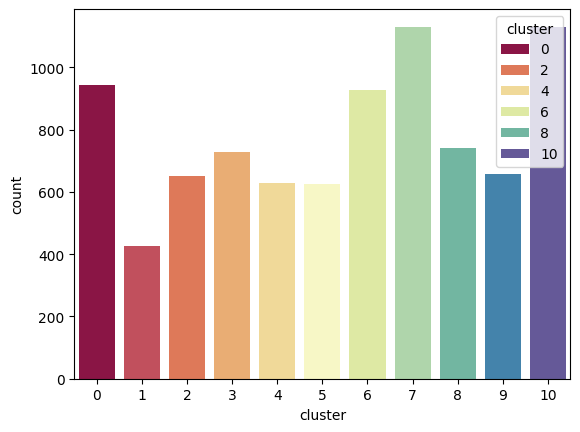

In [31]:
# Plot distribution of the clusters
sns.countplot(data=df, x='cluster', hue='cluster', palette='Spectral');

In [32]:
# Feature reduction
reducer = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = reducer.fit_transform(mini_emb)

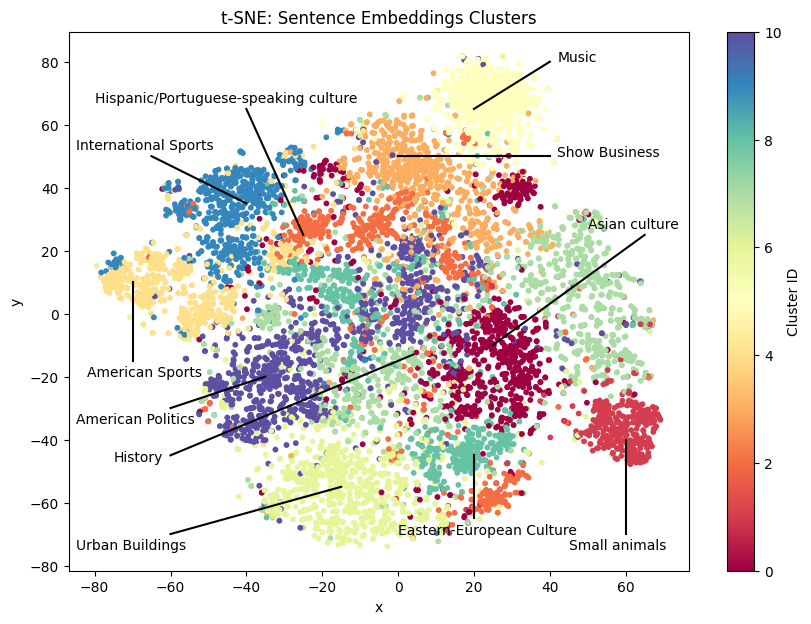

In [33]:
# Visualization
plt.figure(figsize=(10, 7))

# Clusters
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='Spectral', s=10)
plt.title('t-SNE: Sentence Embeddings Clusters')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(scatter, label='Cluster ID')
plt.grid(True)

# Descriptions
plt.plot([25, 65], [-10, 25], 'k-')
plt.annotate('Asian culture', xy=(50, 27))
plt.plot([60, 60], [-70, -40],'k-')
plt.annotate('Animals', xy=(50, -75))
plt.plot([-40, -25], [65, 25],'k-')
plt.annotate('Hispanic/Portuguese-speaking culture', xy=(-80, 67))
plt.plot([0, 40], [50, 50],'k-')
plt.annotate('Show Business', xy=(42, 50))
plt.plot([-70, -70], [-15, 10],'k-')
plt.annotate('Team Sports', xy=(-82, -20))
plt.plot([20, 40], [65, 80],'k-')
plt.annotate('Music', xy=(42, 80))
plt.plot([-60, -15], [-70, -55],'k-')
plt.annotate('Urban Buildings', xy=(-85, -75))
plt.plot([-60, 4], [-45, -13],'k-')
plt.annotate('History', xy=(-75, -47))
plt.plot([20, 20], [-45, -65],'k-')
plt.annotate('Eastern-European Culture', xy=(0, -70))
plt.plot([-65, -40], [50, 35],'k-')
plt.annotate('Sports Events', xy=(-85, 52))
plt.plot([-60, -35], [-30, -20],'k-')
plt.annotate('American Politics', xy=(-85, -35))
plt.show()

### Agglomerative Clustering

#### Determine optimal number of clusters from Dendogram

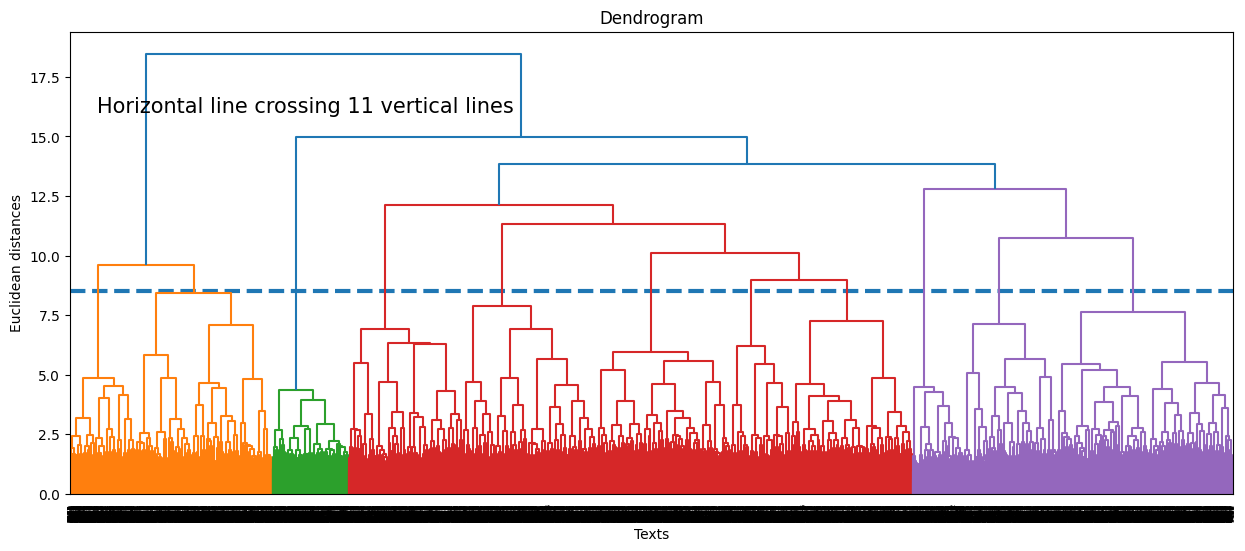

In [50]:
plt.figure(figsize=(15,6))
plt.title('Dendrogram')
plt.xlabel('Texts')
plt.ylabel('Euclidean distances')
plt.hlines(y=8.5, xmin=0, xmax=100000, lw=3, linestyles='--')
plt.text(x=2000, y=16, s='Horizontal line crossing 11 vertical lines',fontsize=15)
dendrogram = sch.dendrogram(sch.linkage(mini_emb, method = 'ward'))
plt.show()

#### Fit model

In [51]:
ac = AgglomerativeClustering(n_clusters= 11, metric='euclidean', linkage='ward')
ac.fit(mini_emb)

AgglomerativeClustering(n_clusters=11)

In [52]:
labels = ac.labels_
df['cluster'] = labels = labels

#### Analyse clusters

In [55]:
cluster0 = df[df['cluster'] == 0]
cluster0.sample(10)

,cluster,title,text
4779,0,1997 UEFA Cup Winners' Cup final,The 1997 UEFA Cup Winners' Cup Final was a foo...
1179,0,Hrant Melkumyan,Hrant Slavayi Melkumyan (Armenian: Հրանտ Սլավա...
4322,0,Fikret Yılmaz,Fikret Yılmaz (born 1 August 1957) is a Turkis...
2393,0,Ben Rohrer,Ben Rohrer (born 26 March 1981) is an Australi...
287,0,2018 UEFA European Under-17 Championship,The 2018 UEFA European Under-17 Championship (...
7503,0,Eduard Krug,Eduard Sergeyevich Krug (Russian: Эдуард Серге...
4617,0,John McEldowney (rugby union),John Thompson McEldowney (26 October 1947 – 17...
5750,0,British Cattle Movement Service,The British Cattle Movement Service (BCMS) is ...
2597,0,Paul Hardy (baseball),"Paul James Hardy (September 17, 1910 – August ..."
3297,0,Anssi Melametsä,"Anssi Ilari Melametsä (born June 21, 1961) is ..."


In [56]:
cluster1 = df[df['cluster'] == 1]
cluster1.sample(10)

,cluster,title,text
4457,1,"Fort Smith, Montana",Fort Smith is a census-designated place (CDP) ...
8218,1,Intermountain Medical Center,Intermountain Medical Center is the flagship h...
6418,1,Relic woods,Relic woods (Russian: Рели́ктовые леса́) is a ...
2180,1,1383 Limburgia,"1383 Limburgia, provisional designation 1934 R..."
8161,1,Kaumana Cave,Kaumana Cave is a lava tube created by a 1881 ...
6973,1,Maja e Bojës,"Maja e Bojës is a 2,461-metre-tall (8,074 ft) ..."
5698,1,Blofield and Flegg Rural District,Blofield and East and West Flegg Rural Distric...
6811,1,"Rawson, North Dakota",Rawson is a now-unincorporated farm community ...
5394,1,"Irwin, Pennsylvania","Irwin is a borough in Westmoreland County, Pen..."
3801,1,Levi G. Nutt,Levi Gamble Nutt was the Chief of the Narcotic...


In [57]:
cluster2 = df[df['cluster'] == 2]
cluster2.sample(10)

,cluster,title,text
6774,2,Alexander Vraciu,"Alexander Vraciu ( vuh-RASH-yoo; November 2, 1..."
3301,2,Deputy governor of Imo State,The Deputy Governor of Imo State is the politi...
6957,2,MV Red Osprey,MV Red Osprey is a Raptor Class vehicle and pa...
2793,2,HMC ML Q055,HMC ML Q055 was a wooden Canadian-built Fairm...
394,2,Strathcona-Sherwood Park,Strathcona-Sherwood Park is a provincial elect...
81,2,Parsons King Johnson,"Parsons King Johnson (May 8, 1816 – November 2..."
6303,2,Jo Comerford,Joanne M. Comerford is an American politician ...
951,2,Félix Tonye Mbog,Félix Tonye Mbog (14 May 1934 – 2 July 2022) w...
3977,2,Susie Rayos Marmon,"Susie Rayos Marmon (née Dawa-Go-Mai-Tsa, 1877–..."
8253,2,Richard A. Mugalian,"Richard Aram Mugalian (April 4, 1922 – March 2..."


In [58]:
cluster3 = df[df['cluster'] == 3]
cluster3.sample(10)

,cluster,title,text
3012,3,Lucy Mary Silcox,Lucy Mary Silcox (11 July 1862 – 11 January 19...
4799,3,Shots in Threequarter Time,Shots in Threequarter Time (German: Schüsse im...
3585,3,Sesame Street's 50th Anniversary Celebration,Sesame Street's 50th Anniversary Celebration i...
4972,3,Kenneth E. Brailsford,Kenneth E. Brailsford is an American multi-lev...
8215,3,Haunted Love,Haunted Love is a horror-romance anthology com...
2503,3,Night Must Fall (1957 film),Night Must Fall is a 1957 British television p...
6619,3,The Summer Book (film),The Summer Book is a 2024 drama film directed ...
1161,3,Classic & Sports Car,Classic & Sports Car is a British monthly maga...
3808,3,Muskoka Queer Film Festival,The Muskoka Queer Film Festival is an annual L...
1363,3,List of Wrecked: Life in the Crash Lane episodes,Wrecked: Life in the Crash Lane is an American...


In [60]:
cluster4 = df[df['cluster'] == 4]
cluster4.sample(10)

,cluster,title,text
300,4,Incheon Women Artists' Biennale,"The Incheon Women Artists' Biennale, held in I..."
2994,4,Sanctuary of the Madonna of Miracles (Corbetta),The Sanctuary of Madonna of Miracles (known of...
8249,4,Ingmar Zahorsky,Ingmar Zahorsky (born 17 February 1983 in Ecke...
4857,4,Washington at Princeton,Washington at Princeton is a 1779 painting by ...
3987,4,"Portrait of the Artist's Uncle, Friedrich Corinth","The Portrait of the Artist's Uncle, Friedrich ..."
7190,4,Muisca rulers,When the Spanish arrived in the central Colomb...
3786,4,El Sexo Débil,El Sexo Débil is a Mexican Spanish language te...
5371,4,Scylla et Glaucus,Scylla et Glaucus (Scylla and Glaucus) is a tr...
7916,4,Anna Kohlweis,"Squalloscope (born Anna Kohlweis, Klagenfurt, ..."
1566,4,Elvira Ríos,"María Elvira Gallegos Ríos (November 16, 1913 ..."


In [61]:
cluster5 = df[df['cluster'] == 5]
cluster5.sample(10)

,cluster,title,text
624,5,Ko Ko Mo (I Love You So),"""Ko Ko Mo (I Love You So)"" is a popular rock n..."
483,5,Happiness (Ai song),"""Happiness"" (ハピネス) is a song written and recor..."
124,5,Solar (Red Garland album),Solar is an album by jazz musician Red Garland...
1973,5,1999 (Charli XCX and Troye Sivan song),"""1999"" is a song by English singer Charli XCX ..."
948,5,Drive by Shooting,Drive by Shooting is a solo EP by American har...
1951,5,Talk About It,Talk About It may refer to:\n== Music ==\nTalk...
1709,5,"B'z The Best ""Pleasure II""","B'z The Best ""Pleasure II"" is the sixth compil..."
6602,5,Deep Politics,Deep Politics is the sixth studio album by Ame...
6518,5,Inferno (Marty Friedman album),Inferno is the eleventh studio album by guitar...
7896,5,Kiss That Frog,"""Kiss That Frog"" is the fourth single from Eng..."


In [62]:
cluster6 = df[df['cluster'] == 6]
cluster6.sample(10)

,cluster,title,text
6442,6,Nagpuri literature,Nagpuri literature refers to literature in the...
5777,6,Yamla Pagla Deewana: Phir Se,Yamla Pagla Deewana: Phir Se (transl. Crazy ma...
5268,6,Nkumba University,Nkumba University (NKU) is a chartered private...
2767,6,Honghu,Honghu (Chinese: 洪湖市; pinyin: Hónghú Shì) is a...
8269,6,Dil Banjaara,Dil Banjaara (Urdu: دل بنجارا lit: Wander Hear...
3408,6,Hang Jebat,Hang Jebat (Jawi: هڠ جيبت‎; born c. 1400) was ...
7151,6,Lobna Abdel Aziz,"Lobna Abdel Aziz, aka Lobna Abdelaziz or Lobna..."
253,6,Timurid relations with Europe,Timurid relations with Europe developed in the...
1050,6,Phra Malai,"Phra Malai Kham Luang (Thai: พระมาลัยคำหลวง, p..."
4335,6,Bilinarra,"The Bilinarra, also spelt Bilingara and Bilina..."


In [64]:
cluster7 = df[df['cluster'] == 7]
cluster7.sample(10)

,cluster,title,text
2231,7,Zinovios Valvis,Zinovios Zafirios I. Valvis (Greek: Ζηνόβιος-Ζ...
2070,7,Henri Delassus,"Henri Delassus (April 12, 1836 – October 6, 1..."
2365,7,Frederiksberg Church,Frederiksberg Church (Danish: Frederiksberg Ki...
1061,7,Drekalovići,The Drekalovići (Cyrillic: Дрекаловићи; Albani...
1423,7,Elisenvaara,Elisenvaara (Russian: Элисенваара; Finnish: El...
1805,7,Mădălin Smaranda,Mădălin Smaranda (born 5 September 1984) is a ...
4284,7,"Kalanak, Tajikistan","Kalanak (Tajik: Қалъанак Qal'anak, Persian: قل..."
4438,7,Fall of Berlin – 1945,"Fall of Berlin – 1945, The Fall of Berlin, or ..."
5614,7,César-François de Saussure,César-François de Saussure (bap. 24 June 1705 ...
954,7,1758 in literature,This article contains information about the li...


In [67]:
cluster8 = df[df['cluster'] == 8]
cluster8.sample(10)

,cluster,title,text
3563,8,Sisu S-321,"Sisu S-321, S-322 and S-323 is the first lorry..."
2828,8,Obliteration by incorporation,"In sociology of science, obliteration by incor..."
6520,8,Biometrology,Biometrology refers to measurement and data ac...
8250,8,Time-sharing,"In computing, time-sharing is the concurrent s..."
5218,8,Project Natick,Project Natick was an experimental data center...
1580,8,CSRD,CSRD may refer to:\nColumbia-Shuswap Regional ...
3387,8,Pomodoro Technique,The Pomodoro Technique is a time management me...
2269,8,Centre for Advanced Study at the Norwegian Aca...,The Centre for Advanced Study at the Norwegian...
398,8,AACR,"AACR may refer to:\nAcross a Crowded Room, an..."
6144,8,Xu Rongmao,Xu Rongmao (simplified Chinese: 许荣茂; traditio...


In [69]:
cluster9 = df[df['cluster'] == 9]
cluster9.sample(10)

,cluster,title,text
3414,9,Caudata,The Caudata are a group of amphibians containi...
1710,9,Carex caryophyllea,Carex caryophyllea is a species of plant in th...
970,9,Eastern Cordillera small-footed shrew,The Eastern Cordillera small-footed shrew (Cry...
2413,9,Crotalus molossus oaxacus,"Crotalus molossus oaxacus, or the Oaxacan blac..."
3721,9,Stenoglene bipartita,Stenoglene bipartita is a moth in the family E...
3809,9,Lusitanops gigasei,Lusitanops gigasei is an extinct species of se...
1636,9,Philippine forest turtle,Siebenrockiella leytensis is a species of fres...
6472,9,Krefft's glider,Krefft's glider (Petaurus notatus) is a specie...
7563,9,Ceriagrion bakeri,Ceriagrion bakeri is a species of damselfly in...
1975,9,Tunisian tortoise,The Tunisian tortoise or Nabeul tortoise (Test...


In [70]:
cluster10 = df[df['cluster'] == 10]
cluster10.sample(10)

,cluster,title,text
4058,10,German 500,The German 500 was an automobile race sanction...
4236,10,List of Malagasy records in swimming,The Malagasy records in swimming are the faste...
8160,10,Cristina Ghiță,Cristina Ghiță (born 16 December 1982) is a re...
2988,10,George Simpson (sprinter),"George Sidney Simpson (September 21, 1908 – De..."
7508,10,Anastasia Grebenkina,Anastasia Yuryevna Grebenkina (Russian: Анаста...
8068,10,Tamás Varga (rower),"Tamas Varga (born 17 June 1978, in Budapest) i..."
6660,10,1985 Brazilian Grand Prix,The 1985 Brazilian Grand Prix (officially know...
1373,10,Cycling at the 2024 Summer Paralympics – Mixed...,The mixed team sprint C1–5 track cycling event...
7038,10,2005 European Speedway Club Champions' Cup,The 2005 European Speedway Club Champions' Cup...
5507,10,Surtees TS9,The Surtees TS9 was a Formula One car used by ...


##### Observations

0. Team sports
1. Cultural heritage
2. Politics, armed forces
3. Authors, movies, TV shows, novels, comics, plays, magasines
4. Paintings, opera, photography
5. Music
6. Asian culture
7. Eastern European Culture
8. Business
9. Animals
10. Speed sports (racing, track and field, cycling, swimming)


#### Visualize clusters

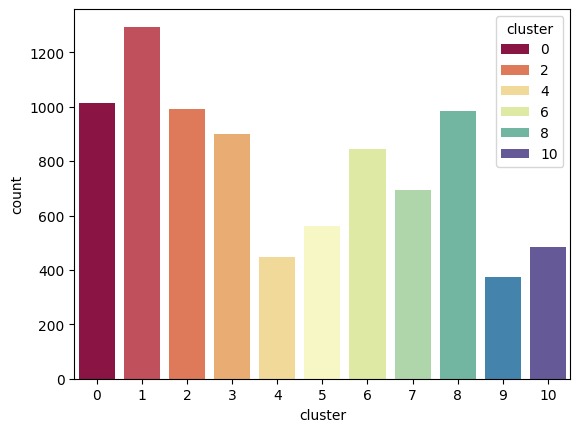

In [53]:
# Plot distribution of the clusters
sns.countplot(data=df, x='cluster', hue='cluster', palette='Spectral');

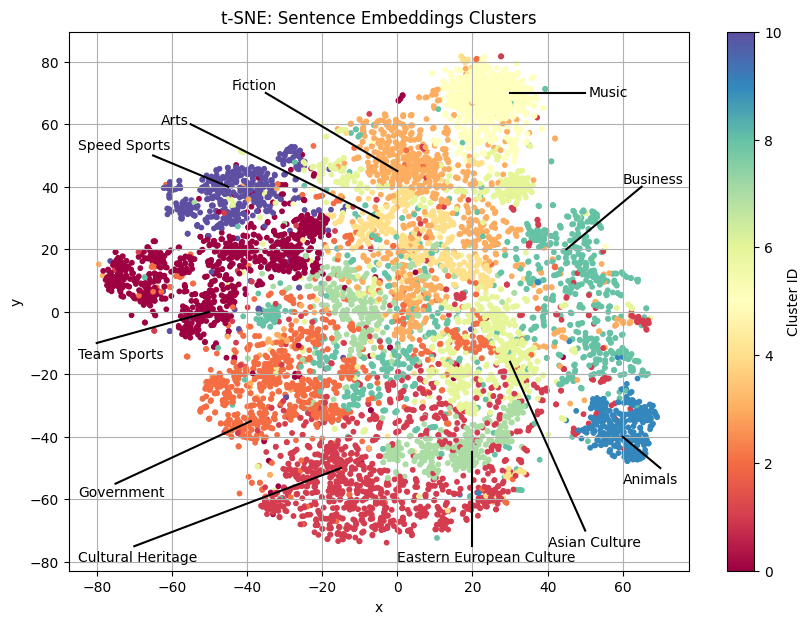

In [139]:
# Visualize clusters
plt.figure(figsize=(10, 7))

# Clusters
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='Spectral', s=10)
plt.title('t-SNE: Sentence Embeddings Clusters')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(scatter, label='Cluster ID')
plt.grid(True)

# Descriptions
plt.plot([-80, -50], [-10, 0], 'k-')
plt.annotate('Team Sports', xy=(-85, -15))
plt.plot([-70, -15], [-75, -50],'k-')
plt.annotate('Cultural Heritage', xy=(-85, -80))
plt.plot([-75, -39], [-55, -35],'k-')
plt.annotate('Government', xy=(-85, -59))
plt.plot([-35, 0], [70, 45],'k-')
plt.annotate('Fiction', xy=(-44, 71))
plt.plot([-55, -5], [60, 30],'k-')
plt.annotate('Arts', xy=(-63, 60))
plt.plot([30, 50], [70, 70],'k-')
plt.annotate('Music', xy=(51, 69))
plt.plot([30, 50], [-16, -70],'k-')
plt.annotate('Asian Culture', xy=(40, -75))
plt.plot([20, 20], [-45, -75],'k-')
plt.annotate('Eastern European Culture', xy=(0, -80))
plt.plot([45, 65], [20, 40],'k-')
plt.annotate('Business', xy=(60, 41))
plt.plot([60, 70], [-40, -50],'k-')
plt.annotate('Animals', xy=(60, -55))
plt.plot([-65, -45], [50, 40],'k-')
plt.annotate('Speed Sports', xy=(-85, 52))
plt.show()

## Interpretation

The clusterings are pretty similar and both make sense. Both created clusters for Asian and Eastern Europe culture, and both have two sports clusters, which is interesting.

## End